## Module Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from collections import defaultdict
from collections import Counter
from shutil import copyfile

## Configuration

In [22]:
data_dir = "Dataset/Plant_Leaf_Dataset"
batch_size = 32
num_epochs = 50
image_size = 224
learning_rate = 0.001
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Data transformations with augmentation

In [23]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Load Dataset From Folder 

In [24]:
full_dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=transform)
class_names = full_dataset.classes
num_classes = len(full_dataset.classes)
print("Class Names:", class_names)

Class Names: ['Apple__Apple_scab', 'Apple__Black_rot', 'Apple__Cedar_apple_rust', 'Apple__healthy', 'Background_without_leaves', 'Bean__Blight', 'Bean__Healthy', 'Bean__Mosaic_Virus', 'Bean__Rust', 'Blueberry__healthy', 'Cherry__Powdery_mildew', 'Cherry__healthy', 'Corn__Cercospora_leaf_spot Gray_leaf_spot', 'Corn__Common_rust', 'Corn__Northern_Leaf_Blight', 'Corn__healthy', 'Cowpea__Bacterial_wilt', 'Cowpea__Healthy', 'Cowpea__Mosaic_virus', 'Cowpea__Septoria_leaf_spot', 'Grape__Black_rot', 'Grape__Esca_(Black_Measles)', 'Grape__Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape__healthy', 'Orange__Haunglongbing_(Citrus_greening)', 'Peach__Bacterial_spot', 'Peach__healthy', 'Pepper__bell__Bacterial_spot', 'Pepper__bell__healthy', 'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy', 'Raspberry__healthy', 'Soybean__healthy', 'Squash__Powdery_mildew', 'Strawberry__Leaf_scorch', 'Strawberry__healthy', 'Tomato__Bacterial_spot', 'Tomato__Early_blight', 'Tomato__Late_blight', 'Tomato__

## EDA


Sample Images:


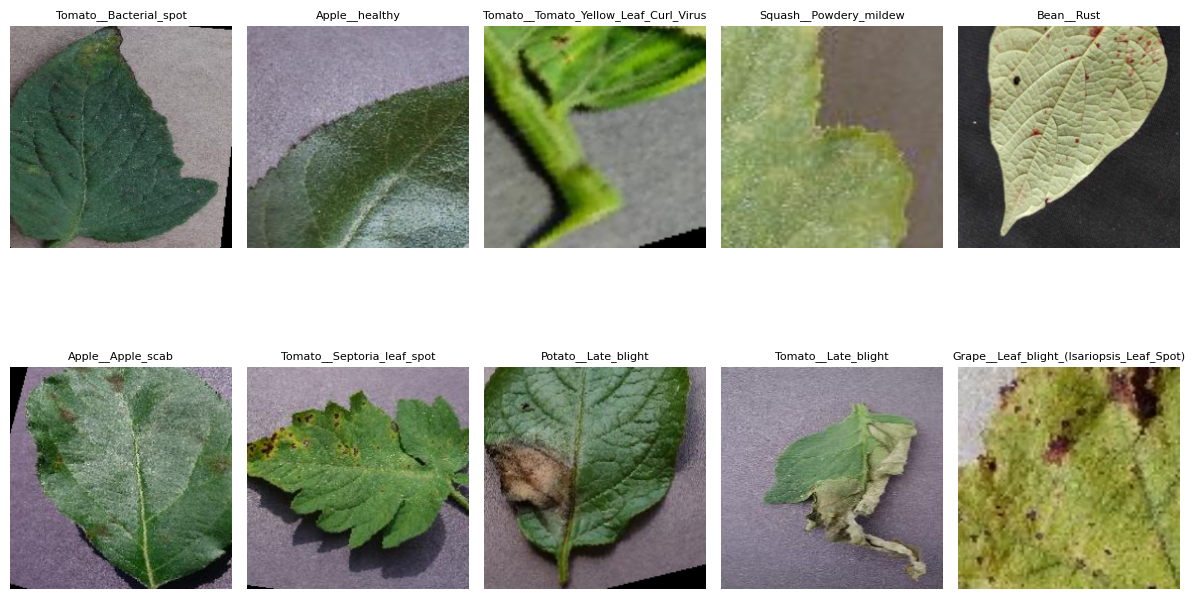


Class Distribution:


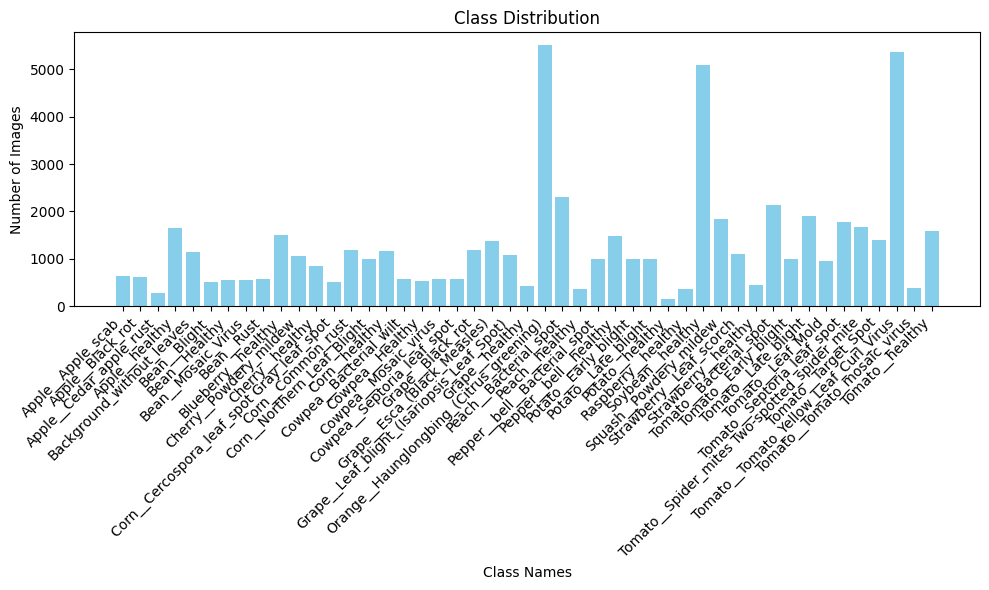

Class Distribution:
Apple__Apple_scab: 630 images
Apple__Black_rot: 621 images
Apple__Cedar_apple_rust: 275 images
Apple__healthy: 1645 images
Background_without_leaves: 1143 images
Bean__Blight: 510 images
Bean__Healthy: 554 images
Bean__Mosaic_Virus: 562 images
Bean__Rust: 568 images
Blueberry__healthy: 1502 images
Cherry__Powdery_mildew: 1052 images
Cherry__healthy: 854 images
Corn__Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn__Common_rust: 1192 images
Corn__Northern_Leaf_Blight: 985 images
Corn__healthy: 1162 images
Cowpea__Bacterial_wilt: 581 images
Cowpea__Healthy: 536 images
Cowpea__Mosaic_virus: 579 images
Cowpea__Septoria_leaf_spot: 577 images
Grape__Black_rot: 1180 images
Grape__Esca_(Black_Measles): 1383 images
Grape__Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape__healthy: 423 images
Orange__Haunglongbing_(Citrus_greening): 5507 images
Peach__Bacterial_spot: 2297 images
Peach__healthy: 360 images
Pepper__bell__Bacterial_spot: 997 images
Pepper__bell__healthy:

In [5]:
# Function to plot sample images
def plot_sample_images(dataset, class_names, num_images=10):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    images = images.numpy()

    # Unnormalize images for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images.transpose((0, 2, 3, 1)) * std + mean
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function to analyze class distribution
def analyze_class_distribution(dataset):
    class_counts = Counter([sample[1] for sample in dataset])
    class_labels = [class_names[i] for i in class_counts.keys()]
    class_sizes = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_sizes, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.title("Class Distribution")
    plt.xlabel("Class Names")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

    print("Class Distribution:")
    for cls, count in zip(class_labels, class_sizes):
        print(f"{cls}: {count} images")

# Function to check image dimensions and formats
def check_image_properties(dataset_path):
    dimensions = []
    formats = []

    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if not os.path.isdir(class_path):
            continue

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    dimensions.append(img.size)
                    formats.append(img.format)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    # Analyze dimensions
    dimension_counts = Counter(dimensions)
    print("Unique Image Dimensions:")
    for dim, count in dimension_counts.items():
        print(f"{dim}: {count} images")

    # Analyze formats
    format_counts = Counter(formats)
    print("\nImage Formats:")
    for fmt, count in format_counts.items():
        print(f"{fmt}: {count} images")

# Run EDA
print("\nSample Images:")
plot_sample_images(full_dataset, class_names)

print("\nClass Distribution:")
analyze_class_distribution(full_dataset)

print("\nImage Properties:")
check_image_properties(data_dir)


In [25]:
#Train Test Validation Split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [26]:
#Export Images From Test Dataset For Future Testing

output_dir = "Tests/test_images"
os.makedirs(output_dir, exist_ok=True)

class_counts = defaultdict(int)
for image_path, label in test_data.dataset.samples:
    if class_counts[label] < 5:

        class_name = class_names[label]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        
        output_path = os.path.join(class_dir, os.path.basename(image_path))
        copyfile(image_path, output_path)
        
        class_counts[label] += 1

    if len(class_counts) == len(class_names) and all(count >= 5 for count in class_counts.values()):
        break

print(f"Exported 5 images per class to {output_dir}")

Exported 5 images per class to Tests/test_images


In [27]:
# Modified ResNet Model to add Dropout Layer
class ModifiedResNet(nn.Module):
    def __init__(self, base_model, num_classes):
        num_features = base_model.fc.in_features
        super(ModifiedResNet, self).__init__()
        # Extract all layers except the last (fully connected)
        self.base = nn.Sequential(*list(base_model.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling for fixed-size output
        self.fc = nn.Sequential(
            nn.Dropout(0.3),  # Dropout to prevent overfitting
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        x = self.base(x)  # Feature extraction
        x = self.pool(x)  # Adaptive pooling
        x = torch.flatten(x, 1)  # Flatten
        x = self.fc(x)  # Classification layer
        return x

In [28]:
# Model Setup
base_model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
model = ModifiedResNet(base_model, num_classes)
model = model.to(device)

In [29]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [30]:
# Validation function
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [31]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [32]:
early_stopping = EarlyStopping(patience=3, delta=0.01)

In [33]:
# Training function
def train_model():
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


In [34]:
def save_model(model, file_path="Saved-Models/leaf_disease_model.pth"):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [35]:
if __name__ == "__main__":
    train_model()
    save_model(model, file_path="Saved-Models/leaf_disease_model.pth")

Epoch [1/50]
  Training Loss: 0.8159, Training Accuracy: 75.81%
  Validation Loss: 0.4132, Validation Accuracy: 87.14%
Epoch [2/50]
  Training Loss: 0.4291, Training Accuracy: 86.87%
  Validation Loss: 0.4448, Validation Accuracy: 86.39%
Epoch [3/50]
  Training Loss: 0.3649, Training Accuracy: 88.61%
  Validation Loss: 0.2887, Validation Accuracy: 90.41%
Epoch [4/50]
  Training Loss: 0.3304, Training Accuracy: 89.61%
  Validation Loss: 0.2646, Validation Accuracy: 91.47%
Epoch [5/50]
  Training Loss: 0.3005, Training Accuracy: 90.57%
  Validation Loss: 0.2653, Validation Accuracy: 91.84%
Epoch [6/50]
  Training Loss: 0.2852, Training Accuracy: 91.13%
  Validation Loss: 0.3871, Validation Accuracy: 87.70%
Epoch [7/50]
  Training Loss: 0.2583, Training Accuracy: 91.82%
  Validation Loss: 0.2025, Validation Accuracy: 93.56%
Epoch [8/50]
  Training Loss: 0.2547, Training Accuracy: 92.03%
  Validation Loss: 0.2314, Validation Accuracy: 92.58%
Epoch [9/50]
  Training Loss: 0.2410, Training A

In [47]:
def load_model(base_model, num_classes, file_path="Saved-Models/leaf_disease_model.pth"):
    # Create an instance of the custom ModifiedResNet model
    model = ModifiedResNet(base_model, num_classes)
    
    # Check if the model checkpoint exists
    if os.path.exists(file_path):
        model.load_state_dict(torch.load(file_path, map_location=device))
        model = model.to(device)
        print(f"Model loaded from {file_path}")
    else:
        print(f"No model found at {file_path}. Starting with a fresh model.")
    
    return model

In [48]:
base_model = models.resnet18(weights=None)  # Initialize ResNet-18 without pretrained weights
loaded_model = load_model(base_model, num_classes, file_path="Saved-Models/leaf_disease_model.pth")

/tmp/ipykernel_25082/3183590567.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=device))


Model loaded from Saved-Models/leaf_disease_model.pth


In [38]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

In [39]:
test_accuracy = test_model(loaded_model, test_loader)

Test Loss: 0.1643, Test Accuracy: 94.63%


In [40]:
def predict_image(image_path, model, class_names):
    # Transform the image to match the model's input
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to the model's input size
        transforms.ToTensor(),         # Convert to Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    
    # Open the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)  # Get the class with the highest score
    
    return class_names[predicted_class.item()]


In [41]:
def predict_directory(directory_path, model, class_names):
    for subdir in os.listdir(directory_path):
        subdir_path = os.path.join(directory_path, subdir)
        
        # Skip if not a directory
        if not os.path.isdir(subdir_path):
            continue
        
        print(f"\nProcessing directory: {subdir}")
        
        # Iterate through the first 5 images in the directory
        for idx, image_name in enumerate(sorted(os.listdir(subdir_path))[:5]):
            image_path = os.path.join(subdir_path, image_name)
            
            # Skip non-image files
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            # Predict the class of the image
            predicted_class = predict_image(image_path, model, class_names)
            print(f"Image {idx + 1}: {image_name} -> Predicted class: {predicted_class}")

In [42]:
# Predict the Test Images
test_directory = "Tests/test_images"
predict_directory(test_directory, loaded_model, class_names)


Processing directory: Apple__Apple_scab
Image 1: image (1).jpg -> Predicted class: Apple__Apple_scab
Image 2: image (10).jpg -> Predicted class: Apple__Apple_scab
Image 3: image (100).jpg -> Predicted class: Apple__Apple_scab
Image 4: image (101).jpg -> Predicted class: Apple__Apple_scab
Image 5: image (102).jpg -> Predicted class: Apple__Apple_scab

Processing directory: Apple__Black_rot
Image 1: image (1).jpg -> Predicted class: Apple__Black_rot
Image 2: image (10).jpg -> Predicted class: Apple__Black_rot
Image 3: image (100).jpg -> Predicted class: Apple__Black_rot
Image 4: image (101).jpg -> Predicted class: Apple__Black_rot
Image 5: image (102).jpg -> Predicted class: Apple__Black_rot

Processing directory: Apple__Cedar_apple_rust
Image 1: image (1).jpg -> Predicted class: Apple__Cedar_apple_rust
Image 2: image (10).jpg -> Predicted class: Apple__Cedar_apple_rust
Image 3: image (100).jpg -> Predicted class: Apple__Cedar_apple_rust
Image 4: image (101).jpg -> Predicted class: Appl

In [43]:
# Predict Single Image
image_path = "Tests/test_images/Tomato__Tomato_Yellow_Leaf_Curl_Virus/image (1).jpg"
predict_image(image_path, loaded_model, class_names)


'Tomato__Tomato_Yellow_Leaf_Curl_Virus'

# Conver .pth model to .onnx format

In [44]:
def convert_to_onnx(model, input_size, onnx_file_path="leaf_disease_model.onnx"):
    # Dummy input for tracing
    dummy_input = torch.randn(1, *input_size).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Export the model
    torch.onnx.export(
        model, 
        dummy_input, 
        onnx_file_path, 
        export_params=True,        # Store the trained weights
        opset_version=11,          # ONNX opset version (11 is commonly used)
        do_constant_folding=True,  # Optimize constants
        input_names=['input'],     # Name for the input tensor
        output_names=['output'],   # Name for the output tensor
        dynamic_axes={
            'input': {0: 'batch_size'}, 
            'output': {0: 'batch_size'}
        }  # Allow for dynamic batch size
    )
    print(f"Model has been converted to ONNX and saved at {onnx_file_path}")

In [45]:
base_model = models.resnet18(weights=None)  # Load ResNet-18
num_classes = len(full_dataset.classes)  # Number of classes
loaded_model = ModifiedResNet(base_model, num_classes)  # Custom model
loaded_model = load_model(base_model, num_classes, file_path="Saved-Models/leaf_disease_model.pth")  # Load weights

Model loaded from Saved-Models/leaf_disease_model.pth


/tmp/ipykernel_25082/3183590567.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=device))


In [46]:
# Convert to ONNX
convert_to_onnx(loaded_model, input_size=(3, 224, 224), onnx_file_path="FastAPI/model/leaf_disease_model.onnx")

Model has been converted to ONNX and saved at FastAPI/model/leaf_disease_model.onnx
